# RAPL Energy Consumption

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numba

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from pathlib import Path
import time
import math
from matplotlib import pyplot as plt
import subprocess
import numpy as np


**Note:** this notebook is meant to be executed on the supplied Docker image.

This notebook provides ...

## RAPL sysfs Interface

Set the `cpu_zone` as in lab 02:

In [5]:
cpu_zone = '/sys/devices/virtual/powercap/...'  # complete this path

In [6]:
cpu_zone = '/sys/devices/virtual/powercap/intel-rapl/intel-rapl:0'

Let's verify whether this zone seems like the zone of your CPU.

In [7]:
if os.path.isdir(cpu_zone):
    print('✓ Zone exists')
else:
    print('✗ Zone does not exist!')

name = Path(f'{cpu_zone}/name').read_text().strip()

if name.startswith('package-'):
    print('✓ Its name starts with \'package-\'')
else:
    print('✗ Its zone does not start with \'package-\'!')

if os.path.isfile(f'{cpu_zone}/energy_uj'):
    print('✓ File \'energy_uj\' exists')
else:
    print('✗ File \'energy_uj\' does not exist!')

✓ Zone exists
✓ Its name starts with 'package-'
✓ File 'energy_uj' exists


Complete the following code as in lab 02

In [8]:
from random import randrange

def energy_uj():
    # return randrange(300)
    # TODO verify
    with open(f"{cpu_zone}/energy_uj") as energy_file:
        return int(energy_file.readline())

def mock_energy(time, powercap):
    print(time*powercap)
    return 8 * time * powercap + randrange(80)

print(f'Current energy counter value: {energy_uj()}')

def max_energy():
   # return 300
   # TODO verify
   with open(f"{cpu_zone}/max_energy_range_uj") as file:
        return int(file.readline())

def energy_consumption(energy_uj_start, energy_uj_end):
    # TODO verify
    # return randrange(300)
    return energy_uj_end - energy_uj_start if energy_uj_end > energy_uj_start else max_energy() - energy_uj_start + energy_uj_end

Current energy counter value: 29335132787


In [9]:
def set_powercap(watts_limit: int):
    # pass
    # TODO short term vs long term?
    with open(f"{cpu_zone}/constraint_0_power_limit_uw", "w") as file:
        file.write(str(watts_limit * 1_000_000))
    with open(f"{cpu_zone}/constraint_1_power_limit_uw", "w") as file:
        return file.write(str(watts_limit * 1_000_000))

In [10]:
def edp(energy: float, time: float):
    return energy * time

def chASz(energy: float, time: float, min_energy: float, init_time: float):
    return (energy - min_energy * 0.9) * (time - init_time * 0.9)

def eds(energy: float, time: float, alpha: float, beta: float):
    return alpha * energy + beta * time

def edd(energy: float, time: float, alpha: float, beta: float):
    return math.sqrt((alpha * energy)**2 + (beta * time)**2)

def percent_diff(energy: float, time: float, init_energy: float, init_time: float):
    return (init_energy-energy)/init_energy - (time - init_time)/init_time


 No input file inputbt.data. Using compiled defaults


 NAS Parallel Benchmarks 4.1 Serial Python version - BT Benchmark

 Size:   12x  12x  12
 Iterations:   60    dt:   0.010000
 Time step    1
 Time step   20
 Time step   40
 Time step   60
 Verification being performed for class_npb S
 accuracy setting for epsilon =  1.0000000000000E-08
 Comparison of RMS-norms of residual
           1 1.7034283709540E-01 1.7034283709541E-01 7.2019256173574E-14
           2 1.2975252070029E-02 1.2975252070034E-02 3.6806173040703E-13
           3 3.2527926989482E-02 3.2527926989486E-02 1.2756603136369E-13
           4 2.6436421275145E-02 2.6436421275167E-02 8.0776614077239E-13
           5 1.9211784131747E-01 1.9211784131744E-01 1.3493649234879E-13
 Comparison of RMS-norms of solution error
           1 4.9976913345802E-04 4.9976913345812E-04 1.9633124585146E-13
           2 4.5195666782973E-05 4.5195666782962E-05 2.4124012041720E-13
           3 7.3973765172966E-05 7.3973765172921E-05 6.06599073453

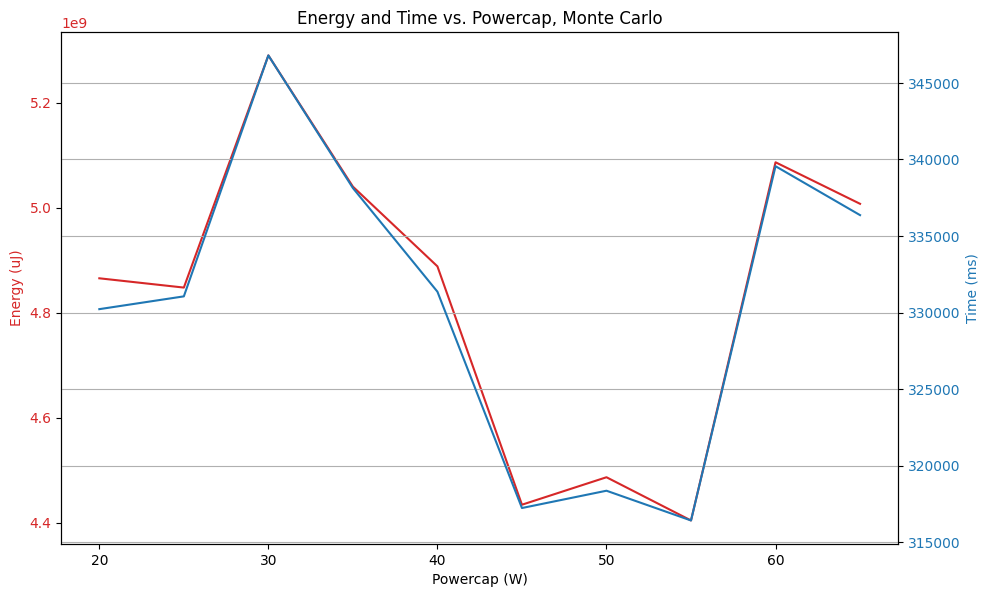

In [11]:
from math import sin, cos, radians

def run_task(pi_monte_carlo: bool, *args):
    type = 'S'
    os.system(f'python3 BT.py -c {type}')    

def benchmark_once(pi_monte_carlo: bool, powercap_w: int, *args):
    set_powercap(powercap_w)

    time1 = time.time()
    energy1 = energy_uj()
    time.sleep(300/powercap_w**1.5)
    run_task(pi_monte_carlo, *args)
    time2 = time.time()
    energy2 = energy_uj()


    total_time = time2 - time1
    total_energy = energy_consumption(energy1, energy2)

    return total_time * 1000, total_energy

def benchmark_ntimes(pi_monte_carlo: bool, times: int, powercap_w: int, *args):

    total_time = 0
    total_energy = 0
    min_time = 1e9
    min_energy = 1e9
    max_time = 0
    max_energy = 0
    
    for _ in range(times):
        response = benchmark_once(pi_monte_carlo, powercap_w, *args)
        total_time += response[0]
        total_energy += response[1]

        min_time = min(min_time, response[0])
        min_energy = min(min_energy, response[1])
        
        max_time = max(max_time, response[0])
        max_energy = max(max_energy, response[1])
        
    avg_time = (total_time - min_time - max_time) / (times - 2)
    avg_energy = (total_energy - min_energy - max_energy) / (times - 2)
    return avg_time, avg_energy

tested_powercaps = [i for i in range(20, 70, 5)]

energies = []
times = []
ntimes = 4
use_monte_carlo = True
text = 'Monte Carlo' if use_monte_carlo else 'Mnożenie macierzy'
file_name = 'monte_carlo' if use_monte_carlo else 'matrix_multiply'

for powercap in tested_powercaps:
    time_result, energy_result = benchmark_once(use_monte_carlo, ntimes, powercap)
    # time_result, energy_result = benchmark_ntimes(use_monte_carlo, ntimes, powercap)
    energies.append(energy_result)
    times.append(time_result)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Powercap (W)')
ax1.set_ylabel('Energy (uJ)', color=color)
ax1.plot(tested_powercaps, energies, color=color, label='Energy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Time (ms)', color=color)
ax2.plot(tested_powercaps, times, color=color, label='Time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Energy and Time vs. Powercap, {text}')
plt.grid(True)
plt.savefig(f'{file_name}.png')
plt.show()

In [12]:
edps = []
eds_values = []
edds = []
percent_diffs = []
chASzs = []

initial_time, initial_energy = times[-1], energies[-1]
k_values = [1.5, 2]
# alpha = 0.5  # You can adjust these coefficients according to your needs
# beta = 0.5

alpha_values = [(k - 1) / (k * initial_energy) for k in k_values]
beta_values = [1 / (k * initial_time) for k in k_values]
eds_values = [[] for _ in k_values]
edds = [[] for _ in k_values]

for i in range(len(times)):
    time_result, energy_result = times[i], energies[i]
    edps.append(edp(energy_result, time_result))
    chASzs.append(chASz(energy_result, time_result, min(energies), initial_time))
    percent_diffs.append(percent_diff(energy_result, time_result, initial_energy, initial_time))
    for j, (alpha, beta) in enumerate(zip(alpha_values, beta_values)):
        eds_values[j].append(eds(energy_result, time_result, alpha, beta))
        edds[j].append(edd(energy_result, time_result, alpha, beta))


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


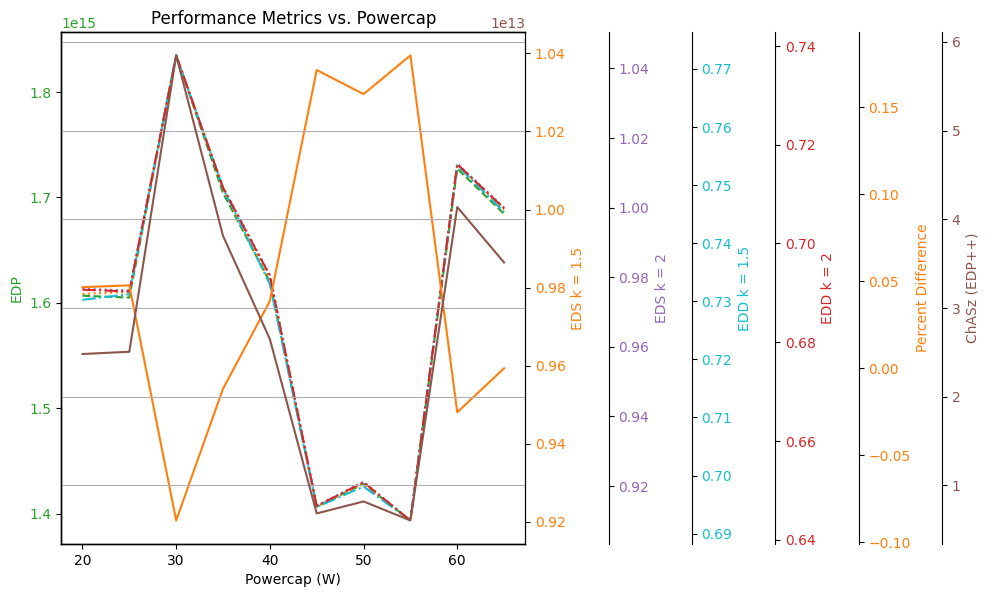

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Powercap (W)')

offset = 0
colors = ['orange', 'purple', 'cyan', 'red', 'orange', 'brown', 'olive', 'pink', 'blue', 'grey']

# EDP plot
color = 'tab:green'
ax1.set_ylabel('EDP', color=color)
ax1.plot(tested_powercaps, edps, color=color, linestyle='--', label='EDP')
ax1.tick_params(axis='y', labelcolor=color)

# EDS plot
for plot, k in zip(eds_values, k_values):
    ax4 = ax1.twinx()
    color = f'tab:{colors[offset // 60]}'
    ax4.spines['right'].set_position(('outward', offset))
    offset += 60
    ax4.set_ylabel(f'EDS k = {k}', color=color)
    ax4.plot(tested_powercaps, plot, color=color, linestyle=':', label='EDS')
    ax4.tick_params(axis='y', labelcolor=color)

# EDD plot
for plot, k in zip(edds, k_values):
    ax5 = ax1.twinx()
    color = f'tab:{colors[offset // 60]}'
    ax5.spines['right'].set_position(('outward', offset))
    offset += 60
    ax5.set_ylabel(f'EDD k = {k}', color=color)
    ax5.plot(tested_powercaps, plot, color=color, linestyle='-.', label='EDD')
    ax5.tick_params(axis='y', labelcolor=color)

# Percent Difference plot
ax6 = ax1.twinx()
color = f'tab:{colors[offset // 60]}'
ax6.spines['right'].set_position(('outward', offset))
offset += 60
ax6.set_ylabel('Percent Difference', color=color)
ax6.plot(tested_powercaps, percent_diffs, color=color, linestyle='-', label='Percent Difference')
ax6.tick_params(axis='y', labelcolor=color)

ax7 = ax1.twinx()
color = f'tab:{colors[offset // 60]}'
ax7.spines['right'].set_position(('outward', offset))
offset += 60
ax7.set_ylabel('ChASz (EDP++)', color=color)
ax7.plot(tested_powercaps, chASzs, color=color, linestyle='-', label='ChASz (EDP++)')
ax7.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Performance Metrics vs. Powercap')
plt.grid(True)
plt.show()

0.529242759817188


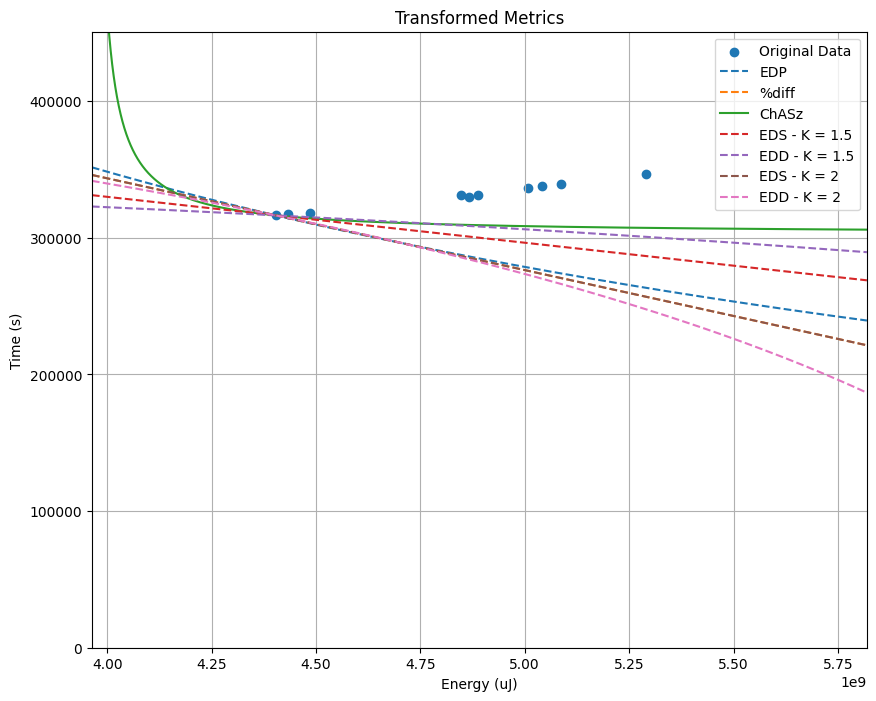

In [17]:

def trans_edp(E):
    # c = 500
    c = min([edp(e, t) for e, t in zip(energies, times)])
    omega = 0 # min(energies) - 1
    theta = 0 # min(times) - 1
    return c/(E-omega) + theta

def f_trans_eds(index):
        
    def trans_eds(E):
        # c = -390
        alpha = alpha_values[index]
        beta = beta_values[index]
        c = min([eds(e, t, alpha, beta) for e, t in zip(energies, times)])
        return -alpha/beta * E + c/beta
    
    return trans_eds;

def f_trans_edd(index):

    def trans_edd(E):
        # c = alpha * max(energies) + 0.001
        # c =  370
        alpha = alpha_values[index]
        beta = beta_values[index]
        c = min([edd(e, t, alpha, beta) for e, t in zip(energies, times)])
        d = c**2 - (alpha*E)**2
        if d < 0:
            return None
        return np.sqrt(d)/beta
    
    return trans_edd;

def trans_percent_diff(E):
    # c = 10
    c = max([percent_diff(e, t, initial_energy, initial_time) for e, t in zip(energies, times)])
    return ((initial_energy - E)/initial_energy - c + 1) * initial_time


def trans_chasz(E):
    # c = 500
    c = min([chASz(e, t, min(energies), initial_time) for e, t in zip(energies, times)])
    omega = min(energies) * 0.9  # min(energies) - 1
    theta = initial_time * 0.9# min(times) - 1
    if E - omega == 0:
        return None
    return c/(E-omega) + theta

print(alpha * max(energies) + 0.001)

transformed_metrics = \
{
    "EDP": trans_edp,
    "%diff": trans_percent_diff,
    "ChASz": trans_chasz
}

for i, k in enumerate(k_values):
    transformed_metrics[f"EDS - K = {k}"] = f_trans_eds(i)
    transformed_metrics[f"EDD - K = {k}"] = f_trans_edd(i)
      
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original data
ax.scatter(energies, times, label='Original Data', color='tab:blue')
ax.set_ylim([0, max(times) * 1.3] )
ax.set_xlim([0.9 * min(energies), max(energies) * 1.1] )

# Plot transformed metrics
for label, metric_func in transformed_metrics.items():
    energy_range = np.linspace(0.9 * min(energies), max(energies) * 1.1, 20000)
    time_range = [metric_func(energy) for energy in energy_range]
    ax.plot(energy_range, time_range, label=label, linestyle="-" if label == "ChASz" else '--')

ax.set_xlabel('Energy (uJ)')
ax.set_ylabel('Time (s)')
ax.set_title('Transformed Metrics')
ax.legend()

ax.figure.set_figheight(8)
# ax.figure(figsize = (6,10))
plt.grid(True)
plt.show()

In [18]:
print(energies, times)

[4865514582, 4847827982, 5290350593, 5040249731, 4888266417, 4433925783, 4486293996, 4403900286, 5086679238, 5007499388] [330221.7307090759, 331056.8814277649, 346791.0346984863, 338130.1829814911, 331362.17641830444, 317235.31460762024, 318364.7623062134, 316422.25766181946, 339556.0038089752, 336361.9477748871]


In [19]:
print(alpha_values, beta_values)

[6.656682457757962e-11, 9.985023686636943e-11] [1.98199193183659e-06, 1.4864939488774426e-06]
